In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

In [ ]:
def parse_triangulation_file(file_path):
    """
    Parse a triangulation file and extract all triangulation blocks.
    
    Parameters:
    -----------
    file_path : str
        Path to the triangulation file
        
    Returns:
    --------
    list of dict
        Each dict contains:
        - 'points': list of (x, y) tuples
        - 'triangles': list of triangles, each as a list of point indices
        - 'segments': list of segments, each as a list of two point indices
    """
    triangulations = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Look for the start of a triangulation block
        if line.startswith("Final triangulation:"):
            points = []
            triangles = []
            
            i += 1  # Move past the header
            
            # Skip empty lines
            while i < len(lines) and not lines[i].strip():
                i += 1
            
            # Parse points
            while i < len(lines):
                line = lines[i].strip()
                if line.startswith("Point"):
                    parts = line.split()
                    # Format: "Point    0:  1.5  -0.5"
                    x = float(parts[2])
                    y = float(parts[3])
                    points.append((x, y))
                    i += 1
                else:
                    break
            
            # Skip empty lines
            while i < len(lines) and not lines[i].strip():
                i += 1
            
            # Parse triangles
            while i < len(lines):
                line = lines[i].strip()
                if line.startswith("Triangle"):
                    parts = line.split()
                    # Format: "Triangle    0 points:     2     1     0"
                    idx1 = int(parts[3])
                    idx2 = int(parts[4])
                    idx3 = int(parts[5])
                    triangles.append([idx1, idx2, idx3])
                    i += 1
                else:
                    break
            
            # Skip empty lines
            while i < len(lines) and not lines[i].strip():
                i += 1
            
            # Parse segments
            while i < len(lines):
                line = lines[i].strip()
                if line.startswith("Segment"):
                    parts = line.split()
                    # Format: "Segment    0 points:     0     1"
                    idx1 = int(parts[3])
                    idx2 = int(parts[4])
                    i += 1
                else:
                    break
            
            # Store this triangulation
            if points and triangles:
                triangulations.append({
                    'points': points,
                    'triangles': triangles,
                })
        else:
            i += 1
    
    return triangulations

In [6]:
# Parse and plot all triangulations
triangulations = parse_triangulation_file('definegeometry.out')

print(f"Total triangulation blocks: {len(triangulations)}")

# Get the final triangulation
final_tri = triangulations[-1]
print(f"\nFinal triangulation:")
print(f"  Points: {len(final_tri['points'])}")
print(f"  Triangles: {len(final_tri['triangles'])}")

Total triangulation blocks: 22

Final triangulation:
  Points: 12
  Triangles: 10


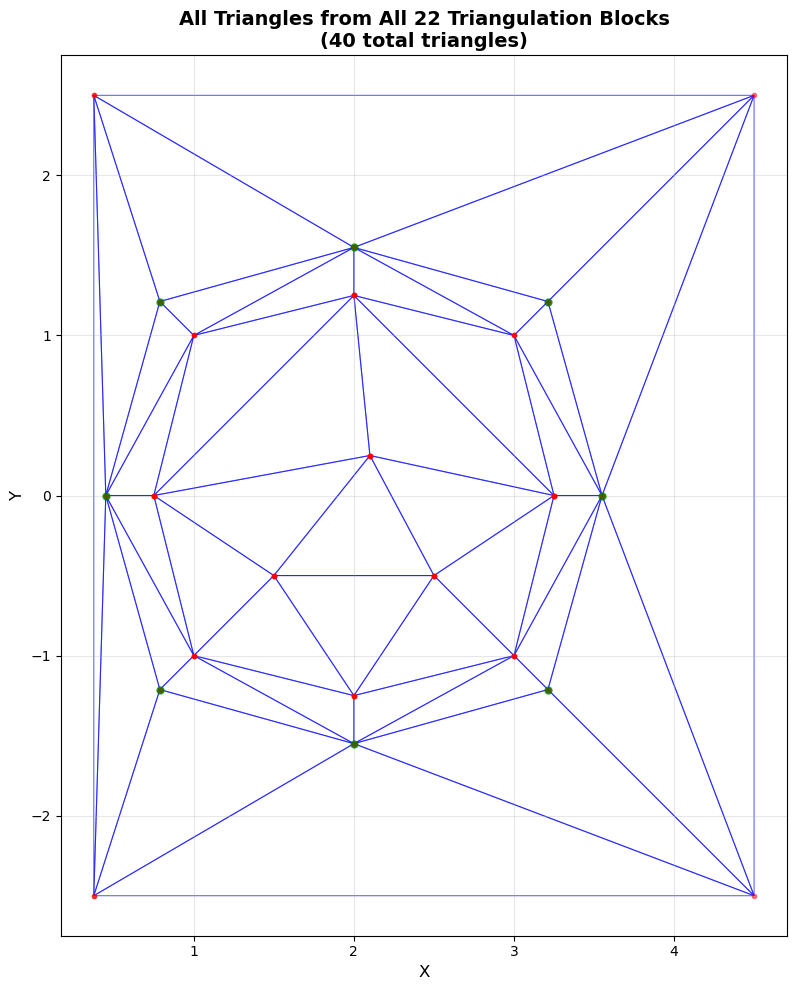


Total triangulation blocks: 22
Total triangles plotted: 40


In [7]:
# Plot ALL triangles from ALL triangulation blocks
fig, ax = plt.subplots(figsize=(12, 10))

total_triangles = 0
all_points = []

# Process each triangulation block
for block_idx, tri_data in enumerate(triangulations):
    points = np.array(tri_data['points'])
    triangles = tri_data['triangles']
    
    # Plot each triangle in this block
    for tri_idx, nodes in enumerate(triangles):
        # Get the three points of the triangle
        p0, p1, p2 = nodes
        triangle_coords = np.array([points[p0], points[p1], points[p2]])
        
        # Create and add the triangle polygon
        poly = Polygon(triangle_coords, fill=False, edgecolor='blue', linewidth=0.8, alpha=0.6)
        ax.add_patch(poly)
        
        total_triangles += 1
    
    # Collect all points for plotting
    all_points.extend(points.tolist())

# Convert to numpy array and plot all unique points
all_points = np.array(all_points)
ax.plot(all_points[:, 0], all_points[:, 1], 'ro', markersize=3, alpha=0.5)

# extra points
extra_points = np.array([
    (2.0, 1.55),
    (3.2121320343559643, 1.2121320343559643),
    (3.55, 0.0),
    (3.2121320343559643, -1.2121320343559643),
    (2.0, -1.55),
    (0.7878679656440357, -1.2121320343559643),
    (0.45, 0.0),
    (0.7878679656440357, 1.2121320343559643)])
ax.plot(extra_points[:, 0], extra_points[:, 1], 'go', markersize=5, alpha=0.7)

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title(f'All Triangles from All {len(triangulations)} Triangulation Blocks\n({total_triangles} total triangles)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.autoscale()
plt.tight_layout()
plt.show()

print(f"\nTotal triangulation blocks: {len(triangulations)}")
print(f"Total triangles plotted: {total_triangles}")

In [8]:
def create_unique_triangulation(triangulations, tol=0.001):
    """
    Create a matplotlib.tri.Triangulation object with all unique points and triangles.
    
    Parameters:
    -----------
    triangulations : list of dict
        List of triangulation blocks
    tol : float
        Tolerance for comparing point coordinates (default: 0.001)
        
    Returns:
    --------
    matplotlib.tri.Triangulation
        Triangulation object containing all unique points and triangles
    """
    import matplotlib.tri as mtri
    
    unique_points = []
    unique_triangles = []
    
    # Process each triangulation block
    for tri_data in triangulations:
        points = np.array(tri_data['points'])
        triangles = tri_data['triangles']
        
        # Map old indices to new indices in the unique points list
        index_map = {}
        
        # Process each point in this block
        for old_idx, point in enumerate(points):
            # Check if this point already exists in unique_points
            found_idx = -1
            for unique_idx, unique_point in enumerate(unique_points):
                distance = np.sqrt(np.sum((np.array(unique_point) - point)**2))
                if distance < tol:
                    found_idx = unique_idx
                    break
            
            # If point is new, add it
            if found_idx == -1:
                found_idx = len(unique_points)
                unique_points.append(tuple(point))
            
            index_map[old_idx] = found_idx
        
        # Process each triangle in this block
        for triangle in triangles:
            # Remap triangle indices to unique point indices
            new_triangle = [index_map[triangle[0]], index_map[triangle[1]], index_map[triangle[2]]]
            
            # Check if this triangle already exists (compare as sorted tuples)
            sorted_new_tri = tuple(sorted(new_triangle))
            is_duplicate = False
            for existing_tri in unique_triangles:
                if tuple(sorted(existing_tri)) == sorted_new_tri:
                    is_duplicate = True
                    break
            
            # Add triangle if it's unique
            if not is_duplicate:
                unique_triangles.append(new_triangle)
    
    # Convert to numpy arrays
    unique_points = np.array(unique_points)
    unique_triangles = np.array(unique_triangles)
    
    # Extract x and y coordinates
    x = unique_points[:, 0]
    y = unique_points[:, 1]
    
    # Create matplotlib triangulation object
    tri_mesh = mtri.Triangulation(x, y, unique_triangles)
    
    return tri_mesh


In [9]:
# Create the unique triangulation object
unique_tri_mesh = create_unique_triangulation(triangulations, tol=0.001)

print(f"Unique triangulation created:")
print(f"  Points: {len(unique_tri_mesh.x)}")
print(f"  Triangles: {len(unique_tri_mesh.triangles)}")
print(f"  Number of edges: {len(unique_tri_mesh.edges)}")

Unique triangulation created:
  Points: 23
  Triangles: 40
  Number of edges: 62


In [10]:
edges = [
    [19, 20],    #0
    [20, 21],    #1
    [21, 22],    #2
    [22, 19],    #3
    [2, 0],      #4
    [0, 1],      #5
    [1, 2],      #6
    [-1, -1],    #7
    [-1, -1],    #8
    [0, 3],      #9
    [3, 1],      #10
    [-1, -1],    #11
    [3, 4],      #12
    [4, 1],      #13
    [-1, -1],    #14
    [-1, -1],    #14
    [5, 0],      #15
    [2, 5],      #16
    [-1, -1],    #17
    [-1, -1],    #17
    [3, 6],      #18
    [6, 4],      #19
    [-1, -1],    #20
    [5, 7],      #21 1138
    [7, 0],      #22
    [-1, -1],    #23
    [-1, -1],    #24 1144
    [7, 3],      #25
    [-1, -1],    #26 1148
    [7, 6],      #27
    [-1, -1],    #28
    [-1, -1],    #29 1154
    [5, 8],      #30
    [8, 7],      #31
    [-1, -1],    #32
    [-1, -1],    #33 1162
    [8, 6],      #34
    [-1, -1],    #35
    [-1, -1],    #36 1168
    [5, 9],      #37
    [9, 8],      #38
    [-1, -1],    #39
    [-1, -1],    #40 1176
    [8, 10],     #41
    [10, 6],     #42
    [-1, -1],    #43 1182
    [11, 10],    #44
    [8, 11],     #45
    [-1, -1],    #46 1188
    [11, 12],    #47
    [12, 10],    #48
    [-1, -1],    #49
    [-1, -1],    #50 1196
    [12, 13],    #51
    [13, 10],    #52
    [-1, -1],    #53 1202
    [13, 6],     #54
    [-1, -1],    #55 1206
    [4, 13],     #56
    [13, 14],    #57
    [14, 4],     #58
    [-1, -1],    #59
    [-1, -1],    #60 1216
    [4, 15],     #61
    [15, 1],     #62
    [-1, -1],    #63 1222
    [14, 15],    #64
    [-1, -1],    #65
    [-1, -1],    #66 1228
    [2, 15],     #67
    [15, 16],    #68
    [16, 2],     #69
    [-1, -1],    #70
    [-1, -1],    #71 1238
    [2, 17],     #72
    [17, 5],     #73
    [16, 17],    #74
    [-1, -1],    #75
    [-1, -1],    #76 1248
    [17, 9],     #77
    [17, 18],    #78
    [18, 9],     #79
    [-1, -1],    #80
    [-1, -1],    #81 1258
    [18, 11],    #82
    [11, 9],     #83
    [-1, -1],    #84
    [-1, -1],    #85 1266
    [20, 17],    #86
    [17, 19],    #87
    [-1, -1],    #88
    [-1, -1],    #89 1274
    [16, 19],    #90
    [-1, -1],    #91
    [-1, -1],    #92 1280
    [15, 19],    #93
    [-1, -1],    #94
    [-1, -1],    #95 1286
    [15, 22],    #96
    [-1, -1],    #97 1290
    [20, 18],    #98
    [-1, -1],    #99
    [-1, -1],    #100 1296
    [20, 11],    #101
    [-1, -1],    #102
    [-1, -1],    #103 1302
    [13, 22],    #104
    [22, 14],    #105
    [-1, -1],    #106
    [-1, -1],    #107
    [-1, -1],    #108 1312
    [13, 21],    #109
    [11, 21],    #110
    [21, 12],    #111
    [-1, -1],    #112
    [-1, -1],    #113
    [-1, -1],    #114
    [-1, -1]     #115
]

# sanity check for edges: check that edge points are not same, and indices are within range, unique edges (including reversed)

valid_edges = []
for edge in edges:
    p1, p2 = edge
    # either both are -1 (invalid edge) or both are valid indices
    if (p1 == -1 and p2 == -1):
        continue
    if p1 == p2:
        print(f"Invalid edge with same points: {edge}")
        continue
    
    # check indices within range
    if p1 < 0 or p1 >= len(unique_tri_mesh.x) or p2 < 0 or p2 >= len(unique_tri_mesh.x):
        print(f"Invalid edge with out-of-range indices: {edge}")
        continue
    # check for uniqueness (consider reversed edges as same)
    if [p2, p1] in valid_edges or [p1, p2] in valid_edges:
        print(f"Duplicate edge found: {edge}")
        continue
    valid_edges.append([p1, p2])

valid_edges = np.array(valid_edges)
print(f"Total valid unique edges: {len(valid_edges)}")
assert unique_tri_mesh.edges.shape[0] == len(valid_edges), "Edge count mismatch!"

Total valid unique edges: 62


In [11]:
# cells
# csr structure of the edges for each cells/triangles (the ids are one based and ignore the sign)
boundaries = [1, 2, 3, 4, 7, -8, 6, 8, 5, 6, -9, -6, 10, 11, 12, -11, 13, 14,
    15, -16, 18, 17, -5, 19, -20, -13, 21, 22, 23, -17, -26, 25, 27, 26, 24,
    25, -25, 28, -10, -29, -28, 30, -21, 31, -32, 33, 34, -24, 35, -36, -30,
    -38, 37, 38, -34, 37, -39, 40, -42, -33, 43, 42, 41, -33, -37, 44, 45,
    -46, -44, 48, 47, -49, -47, 50, 51, 52, -53, 55, -51, 54, -56, -45, -55,
    57, -58, 61, 59, 60, 62, -22, -57, -59, 63, 65, -14, 64, 66, -64, -61,
    67, 68, -69, 71, 72, 70, -73, -70, -7, -65, -74, 75, 76, -18, 77, -75,
    -72, 78, -79, 80, -40, -76, 81, 82, -80, 83, -84, -82, 85, 86, 87, -86,
    -48, -41, 88, 1, 89, 90, 91, -92, -90, -77, 93, 94, -95, -93, -71, 96,
    97, -98, 4, -96, 99, -100, -89, 101, -81, 102, -103, -101, 104, -85, 105,
    -106, 108, -60, 107, -109, -99, -110, -108, 110, -67, -108, -111, -107,
    112, 3, -50, -115, 114, 116, 115, 113, 114, -54, -114, -112, 117, -104,
    2, -113, 118]

# each cells are described using 4 numbers:
# 1. Starting index in the boundaries list (1-based) pointing to the boundaries array
# 2. Number of edges for this cell
# 3. Number of edges + number of cut surfaces (ignore here, we don't need cut surfaces in 2D triangles)
# 4. Zone ID for this cell

# Note: The first cell is a unique case (universal cell encompassing the whole domain), do not consider it.
cells = [
    [1, 4, 4, 0],
    [5, 3, 3, 1],
    [8, 3, 4, 1],
    [12, 3, 4, 2],
    [16, 3, 5, 3],
    [21, 3, 5, 4],
    [26, 3, 4, 5],
    [30, 3, 4, 6],
    [34, 3, 3, 6],
    [37, 3, 4, 7],
    [41, 3, 5, 8],
    [46, 3, 5, 9],
    [51, 3, 3, 10],
    [54, 3, 4, 10],
    [58, 3, 4, 11],
    [62, 3, 3, 11],
    [65, 3, 4, 12],
    [69, 3, 4, 13],
    [73, 3, 5, 13],
    [78, 3, 4, 14],
    [82, 3, 4, 14],
    [86, 3, 4, 15],
    [90, 3, 4, 15],
    [94, 3, 4, 16],
    [98, 3, 5, 16],
    [103, 3, 4, 17],
    [107, 3, 4, 17],
    [111, 3, 3, 18],
    [114, 3, 5, 18],
    [119, 3, 3, 19],
    [122, 3, 5, 19],
    [127, 3, 4, 20],
    [131, 3, 4, 20],
    [135, 3, 5, 21],
    [140, 3, 5, 21],
    [145, 3, 5, 21],
    [150, 3, 4, 21],
    [154, 3, 5, 21],
    [159, 3, 5, 21],
    [164, 3, 4, 21],
    [168, 3, 3, 21],
    [171, 3, 4, 21],
    [175, 3, 3, 21],
    [178, 3, 4, 21],
    [182, 3, 3, 21],
    [185, 3, 4, 21],
    [189, 3, 4, 21]
]

In [12]:
def get_cell_boundaries(cell_id):
    """
    Only the bounding surfaces, no cut surface
    """
    start_boundary, n_boundary, n_tot_boundary, zone_id = cells[cell_id]
    return boundaries[start_boundary-1:start_boundary+n_tot_boundary-1]

In [13]:
get_cell_boundaries(0)

[1, 2, 3, 4]

In [14]:
# degas2 gen_cones function
def gen_cones_all(x0,x1):
    Nsurfs = np.shape(x1)[0] 
    print("Nsurfs:", Nsurfs)
    coeffs = np.zeros([Nsurfs,10])

    eps = 1.0e-8
    eps_angle = np.sqrt(2.0*1.0e-10)

    cylcond = (np.abs(x1[:,0]-x0[:,0]) < eps_angle*np.abs(x1[:,1]-x0[:,1])) 
    cylcond = np.logical_or(cylcond, (np.abs(x1[:,0]-x0[:,0]) < eps))

    planecond = (np.abs(x1[:,1]-x0[:,1]) < eps_angle*np.abs(x1[:,0]-x0[:,0])) 
    planecond = np.logical_or(planecond, (np.abs(x1[:,1]-x0[:,1]) < eps))

    m = np.divide((x1[:,1]-x0[:,1]),(x1[:,0]-x0[:,0]),out=np.ones_like(x1[:,0]),where=np.logical_not(cylcond))
    # m=1 for cylinder, slope for a cone, and 0 for a plane
    m2 = np.where(planecond, np.zeros_like(m), m*m)
    m2 = np.where(cylcond, np.ones_like(m), m2)
    # b = 0 for a cylinder, 1/2 for a plane, and intercept for a cone
    b = np.where(cylcond, np.zeros_like(m), x1[:,1] - m*x1[:,0])
    b = np.where(planecond, 0.5*np.ones_like(m), b)

    # c0 is -b^2 for a cone, -R^2 for a cylinder, -Z0 for a plane
    c0 = np.where( cylcond , -x0[:,0]**2, -b**2)
    c0 = np.where( planecond, -x0[:,1], c0)

    coeffs[:,0] = c0
    coeffs[:,3] = 2.0*b
    coeffs[:,4] = m2
    coeffs[:,5] = m2
    coeffs[:,6] = np.where(np.logical_or(planecond,cylcond),np.zeros(Nsurfs),-np.ones(Nsurfs))

    return coeffs

In [15]:
# surface coefficients from netcdf file
surface_coefficients = [
    [-0.140625, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [1, -0, -0, -0.4, -0, -0, -0, -0, -0, -0],
    [1, -0, -0, -0, -0.0493827160493827, -0.0493827160493827, -0, -0, -0, -0],
    [1, 0, 0, 0.4, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, -1, 0.25, 0.25, -0.25, 0, 0, 0],
    [0.875, -0, -0, -1, -0.642857142857143, -0.642857142857143, 0.285714285714286, -0, -0, -0],
    [-0.375, 0, 0, -1, 0.0416666666666667, 0.0416666666666667, -0.666666666666667, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0], # cut surface
    [-1, 0, 0, 0.571428571428571, 0, 0, 0, 0, 0, 0], # z = 1.75 # maybe a cut surface but not a real edge
    [-0.5, -0, -0, -1, -0, -0, -0, -0, -0, -0],
    [1, -0, -0, 0.470588235294118, -0.124567474048443, -0.124567474048443, 0.055363321799308, -0, -0, -0],
    [1, 0, 0, 0.235294117647059, 0, 0, 0, 0, 0, 0], # z = -4.25 # not a real surface
    [1, -0, -0, -1, -0.25, -0.25, 0.25, -0, -0, -0],
    [0.875, -0, -0, 1, -0.0178571428571429, -0.0178571428571429, 0.285714285714286, -0, -0, -0],
    [1, 0, 0, 0.571428571428571, 0, 0, 0, 0, 0, 0], # z = -1.75 # cut surface
    [-1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0], # z = 2 # maybe cut surface
    [0.25, -0, -0, -1, -0.444444444444444, -0.444444444444444, 1, -0, -0, -0],
    [-0.5625, 0, 0, 0.375, 1, 1, -0.0625, 0, 0, 0],
    [1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0], # z = -2 # maybe cut surface
    [-0.5, 0, 0, 1, 0, 0, 0, 0, 0, 0], # z = 0.5. # maybe
    [-1, 0, 0, -0.923076923076923, 0.0946745562130177, 0.0946745562130177, -0.21301775147929, 0, 0, 0],
    [1, -0, -0, 0.153846153846154, -0.0946745562130177, -0.0946745562130177, 0.00591715976331361, -0, -0, -0],
    [1, 0, 0, 0.0769230769230769, 0, 0, 0, 0, 0, 0], # z = -13.0 # maybe cut
    [-0.0192901234567901, 0, 0, -0.277777777777778, 0.0342935528120713, 0.0342935528120713, -1, 0, 0, 0],
    [1, -0, -0, 0.842105263157895, -0.277008310249307, -0.277008310249307, 0.177285318559557, -0, -0, -0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0.421052631578947, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.477611940298507, -0.200490086879038, -0.200490086879038, 0.0570282913789262, -0, -0, -0],
    [-1, 0, 0, 0.238805970149254, 0, 0, 0, 0, 0, 0],
    [0.353260869565217, -0, -0, -1, -0.0334448160535117, -0.0334448160535117, 0.707692307692308, -0, -0, -0],
    [1, 0, 0, 0.461538461538462, 0, 0, 0, 0, 0, 0],
    [-0.706521739130435, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-0.375, 0, 0, -1, 0.666666666666667, 0.666666666666667, -0.666666666666667, 0, 0, 0],
    [1, -0, -0, -0.0941176470588236, -0.221453287197232, -0.221453287197232, 0.00221453287197232, -0, -0, -0],
    [0.138888888888889, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.0470588235294118, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.615384615384615, -0.0946745562130177, -0.0946745562130177, 0.0946745562130177, -0, -0, -0],
    [-0.25, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.307692307692308, 0, 0, 0, 0, 0, 0],
    [-0.5625, 0, 0, -0.375, 1, 1, -0.0625, 0, 0, 0],
    [-0.375, 0, 0, 1, 0.0416666666666667, 0.0416666666666667, -0.666666666666667, 0, 0, 0],
    [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.75, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.875, -0, -0, -1, -0.0178571428571429, -0.0178571428571429, 0.285714285714286, -0, -0, -0],
    [1, -0, -0, -0.153846153846154, -0.0946745562130177, -0.0946745562130177, 0.00591715976331361, -0, -0, -0],
    [-1, 0, 0, 0.571428571428571, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.754716981132075, -0.0430758276966892, -0.0430758276966892, 0.142399430402278, -0, -0, -0],
    [-1, 0, 0, 0, 0.25, 0.25, 0, 0, 0, 0],
    [-1, 0, 0, 0.377358490566038, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.949001978431532, -0.0174931661108048, -0.0174931661108048, 0.225151188766741, -0, -0, -0],
    [1, -0, -0, 1, -0.25, -0.25, 0.25, -0, -0, -0], 
    # this did not match with any but [4 14] is close, but there's not corner with +2 or -2 = z
    [1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.474500989215766, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.157035821398573, -0.0793493354493156, -0.0793493354493156, 0.00616506230058109, -0, -0, -0],
    [-1, 0, 0, 0.309859154929577, 0.0793493354493156, 0.0793493354493156, -0.024003173973418, 0, 0, 0],
    [-1, 0, 0, 0.0785179106992863, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.154929577464789, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, -0.309859154929577, 0.0793493354493156, 0.0793493354493156, -0.024003173973418, 0, 0, 0],
    [1, -0, -0, 0.157035821398573, -0.0793493354493156, -0.0793493354493156, 0.00616506230058109, -0, -0, -0],
    [-1, 0, 0, 1, 0.25, 0.25, -0.25, 0, 0, 0],
    [1, 0, 0, 0.0785179106992863, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0.154929577464789, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, 0.754716981132075, -0.0430758276966892, -0.0430758276966892, 0.142399430402278, -0, -0, -0],
    [-1, 0, 0, 0, 0.25, 0.25, 0, 0, 0, 0],
    [1, 0, 0, 0.377358490566038, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, 0.949001978431532, -0.0174931661108048, -0.0174931661108048, 0.225151188766741, -0, -0, -0],
    [1, 0, 0, 0.474500989215766, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [0.2025, -0, -0, 0.9, -0.3025, -0.3025, 1, -0, -0, -0],
    [-0.496261417017534, 0, 0, -1, 0.0391402570191792, 0.0391402570191792, -0.503766747579265, 0, 0, 0],
    [-1, 0, 0, -1, 0.25, 0.25, -0.25, 0, 0, 0],
    [0.45, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.75, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-0.2025, 0, 0, 0.495, 1, 1, -0.3025, 0, 0, 0],
    [-0, -0, -0, -1, -0, -0, -0, -0, -0, -0],
    [-0.2025, 0, 0, 0.25086472468422, 1, 1, -0.0776951976430733, 0, 0, 0],
    [1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [-0.818181818181818, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-0.2025, 0, 0, -0.495, 1, 1, -0.3025, 0, 0, 0],
    [-0.2025, 0, 0, -0.25086472468422, 1, 1, -0.0776951976430733, 0, 0, 0],
    [1, -0, -0, -1, -0.25, -0.25, 0.25, -0, -0, -0],
    [0.818181818181818, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [-0.496261417017534, 0, 0, 1, 0.0391402570191792, 0.0391402570191792, -0.503766747579265, 0, 0, 0],
    [0.2025, -0, -0, -0.9, -0.3025, -0.3025, 1, -0, -0, -0],
    [-0.45, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-0.75, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.2025, -0, -0, -0.027, -1, -1, 0.0009, -0, -0, -0],
    [0.2025, -0, -0, 0.027, -1, -1, 0.0009, -0, -0, -0],
    [1, 0, 0, 0.0666666666666667, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.0666666666666667, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, 0.544996906265388, -0.722517531269149, -0.722517531269149, 0.074255406959711, -0, -0, -0],
    [1, 0, 0, 0.272498453132694, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.61941907329437, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, 0.735502121640735, -0.0462219590316275, -0.0462219590316275, 0.135240842734506, -0, -0, -0],
    [1, 0, 0, 0.367751060820368, 0, 0, 0, 0, 0, 0],
    [0.992522834035067, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.395, -0, -0, 1, -0.0913924050632911, -0.0913924050632911, 0.632911392405063, -0, -0, -0],
    [0.79, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.544996906265388, -0.722517531269149, -0.722517531269149, 0.074255406959711, -0, -0, -0],
    [1, 0, 0, 0.61941907329437, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.272498453132694, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.735502121640735, -0.0462219590316275, -0.0462219590316275, 0.135240842734506, -0, -0, -0],
    [-0.992522834035067, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.367751060820368, 0, 0, 0, 0, 0, 0],
    [1, -0, -0, -0.214084507042254, -0.0793493354493156, -0.0793493354493156, 0.0114580440388812, -0, -0, -0],
    [-1, 0, 0, 1, 0.25, 0.25, -0.25, 0, 0, 0],
    [-1, 0, 0, 0.107042253521127, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0.645161290322581, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, -0.214084507042254, 0.0793493354493156, 0.0793493354493156, -0.0114580440388812, 0, 0, 0],
    [-0.395, 0, 0, 1, 0.0913924050632911, 0.0913924050632911, -0.632911392405063, 0, 0, 0],
    [1, -0, -0, 1, -0.25, -0.25, 0.25, -0, -0, -0],
    [-1, 0, 0, 0.645161290322581, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0.107042253521127, 0, 0, 0, 0, 0, 0],
    [-0.79, 0, 0, 1, 0, 0, 0, 0, 0, 0]
]

print("Number of Surfaces: ", len(surface_coefficients))
# sanity checks
# all have exactly 10 coefficients
for nc_coeffs in surface_coefficients:
    assert len(nc_coeffs) == 10, f"Surface coefficient length mismatch for {nc_coeffs}!"


Number of Surfaces:  118


In [16]:
def same_quadratic(c1, c2, tol=1e-10, print_norm=False):
    c1 = np.asarray(c1, dtype=float)
    c2 = np.asarray(c2, dtype=float)

    # Handle zero vector edge case
    if np.allclose(c1, 0, atol=tol) or np.allclose(c2, 0, atol=tol):
        return np.allclose(c1, c2, atol=tol)

    # Normalize both by their largest-magnitude coefficient
    i1 = np.argmax(np.abs(c1))
    i2 = np.argmax(np.abs(c2))

    n1 = c1 / c1[i1]
    n2 = c2 / c2[i2]
    
    if print_norm:
        print(f"Normalized {n1} and {n2}")

    return np.allclose(n1, n2, atol=tol, rtol=tol) or np.allclose(n1, -n2, atol=tol, rtol=tol)

In [17]:
# generate expected coefficients for all edges
nnode = unique_tri_mesh.x.shape[0]
rz=np.zeros([nnode,2])
rz[:,0]=unique_tri_mesh.x
rz[:,1]=unique_tri_mesh.y
calculated_coeffs = gen_cones_all(rz[valid_edges[:,0],:],rz[valid_edges[:,1],:])

edge_connectivity = -1 * np.ones([len(surface_coefficients), 2], dtype=int)

# now for each surface, find which two points it connects. Some may not connect any points (e.g., cut surfaces) and will be marked as [-1,-1]
matched_edge_count = 0
tol = 1e-4
for i, i_calculated_coeffs in enumerate(calculated_coeffs):
    found_for_edge = False
    for j, nc_coeffs in enumerate(surface_coefficients):
        if same_quadratic(i_calculated_coeffs, nc_coeffs, tol, False):
            current_edges = valid_edges[i]
            
            #if (edge_connectivity == current_edges).any():
            #    continue
            
            edge_connectivity[j,:] = current_edges
            matched_edge_count += 1
            found_for_edge = True
            break
    if not found_for_edge:
        print(f"No match found for edge {i}: {current_edges}: with coeffs {i_calculated_coeffs}")

print(f"Matched {matched_edge_count} out of {valid_edges.shape[0]} surfaces to edges.")  

Nsurfs: 62
Matched 62 out of 62 surfaces to edges.


In [18]:
# find cell connectivity (cell to node) from cell to edge, edge to node

def cell_nodes(cell_id):
    cell_boundaries = get_cell_boundaries(cell_id)
    cell_boundaries = np.array(cell_boundaries) - 1
    for boundary in cell_boundaries:
        print(f"Edge {boundary}: {edge_connectivity[abs(boundary)]}")

In [19]:
cell_nodes(2)

Edge 7: [-1 -1]
Edge 4: [21 12]
Edge 5: [0 1]
Edge -10: [3 1]


In [20]:
surface_coefficients[10]

[1,
 0,
 0,
 0.470588235294118,
 -0.124567474048443,
 -0.124567474048443,
 0.055363321799308,
 0,
 0,
 0]

boundary 8 (id 7) is [0,2]


In [21]:
triangle_connectivity = [
    [1, 0, 2],
    
]

### Correct Edge Coefficients
---
According to the `src/geomint.hweb` file, the edge coefficients are defined as follows:
```text
 61 The expression for the $k$th surface is
 62 $$ f_k(x,y,x) = c_0+c_{x} x+c_{y} y+c_{z} z+c_{xx} x^2+c_{yy} y^2+c_{zz} z^2
 63    +c_{xy} x y+c_{yz} y z+c_{xz} x z =0$$
 64 where the $c$'s are coefficients given by |coeff|.
 65
 66 @m NCOEFFS 10
 67 @m c0 1
 68 @m cx 2
 69 @m cy 3
 70 @m cz 4
 71 @m cxx 5
 72 @m cyy 6
 73 @m czz 7
 74 @m cxy 8
 75 @m cyz 9
 76 @m cxz 10
 ```

    [-0.140625, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [1, -0, -0, -0.4, -0, -0, -0, -0, -0, -0],
    [1, -0, -0, -0, -0.0493827160493827, -0.0493827160493827, -0, -0, -0, -0],

In [22]:
zone_centers = [
    [1.5, 0, -0.916666666666667],
    [2, 0, -0.75],
    [2.5, 0, -0.916666666666667],
    [1.08333333333333, 0, -0.5],
    [2.91666666666667, 0, -0.5],
    [1.45, 0, -0.0833333333333334],
    [2.03333333333333, 0, -0.25],
    [2.61666666666667, 0, -0.0833333333333333],
    [1.61666666666667, 0, 0.5],
    [2.45, 0, 0.5],
    [1.25, 0, 0.75],
    [2.75, 0, 0.75],
    [2.33333333333333, 0, 1.26666666666667],
    [3.25404401145199, 0, 0.737377344785321],
    [3.25404401145199, 0, -0.737377344785321],
    [2.33333333333333, 0, -1.26666666666667],
    [1.26262265521468, 0, -1.25404401145199],
    [0.733333333333333, 0, -0.333333333333333],
    [0.733333333333333, 0, 0.333333333333333],
    [1.26262265521468, 0, 1.25404401145199],
    [0.4, 0, 4.25224092048815e-16]
]

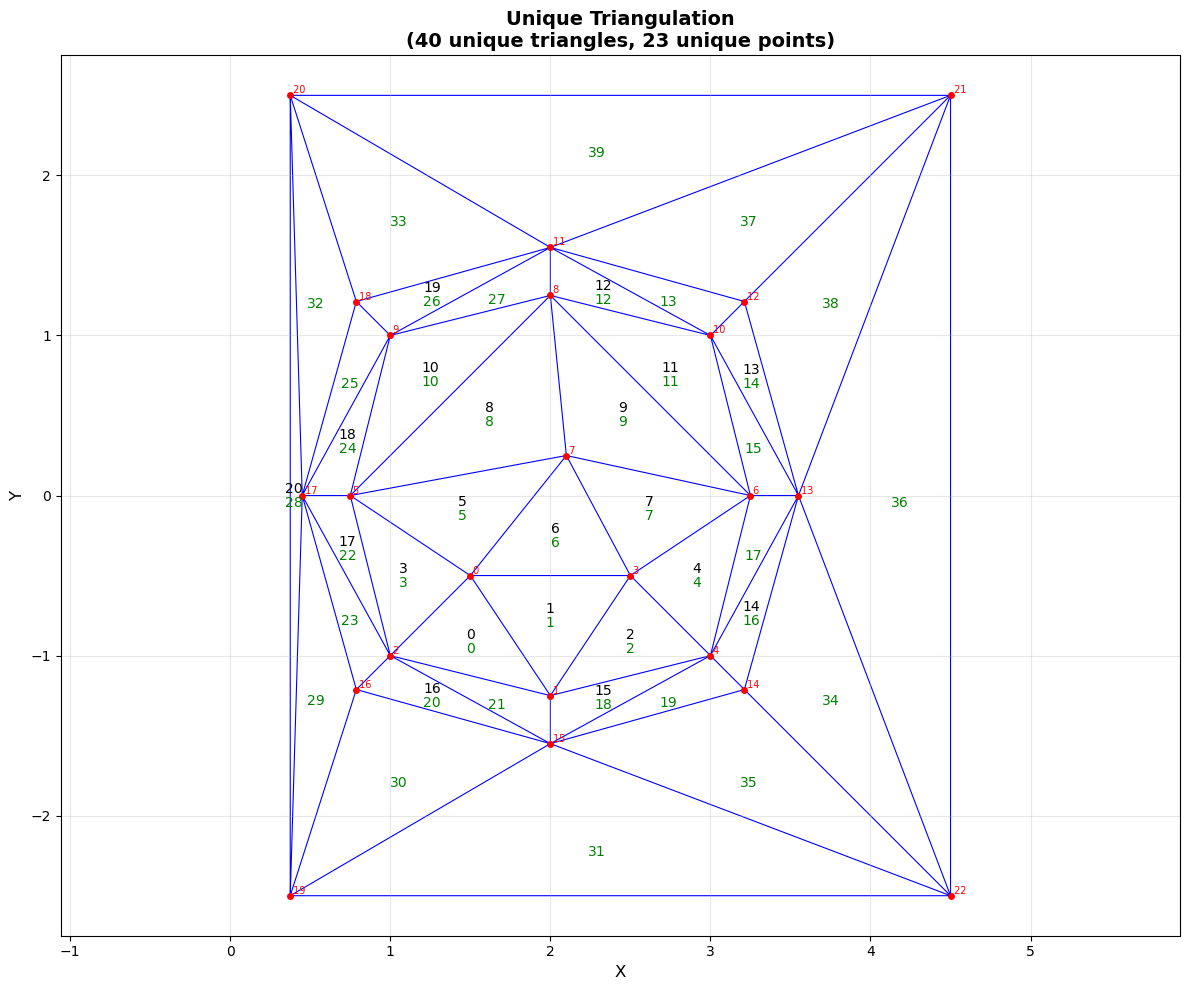

In [23]:
# Plot the unique triangulation
fig, ax = plt.subplots(figsize=(12, 10))

plt.triplot(unique_tri_mesh, 'b-', linewidth=0.8)
plt.plot(unique_tri_mesh.x, unique_tri_mesh.y, 'ro', markersize=4)

# Add point labels
for i, (px, py) in enumerate(zip(unique_tri_mesh.x, unique_tri_mesh.y)):
    plt.text(px, py, f' {i}', fontsize=7, ha='left', va='bottom', color='red')
    # show point coordinates
    
#    plt.text(px, py, f'({px:.3f}, {py:.3f})', fontsize=8, ha='right', va='top', color='black')
    
# print edge ids in the middle of the edges
#for edge_idx, (p1, p2) in enumerate(edge_connectivity):
#    if p1 == -1 or p2 == -1:
#        continue
#    x_mid = (unique_tri_mesh.x[p1] + unique_tri_mesh.x[p2]) / 2
#    y_mid = (unique_tri_mesh.y[p1] + unique_tri_mesh.y[p2]) / 2
#    plt.text(x_mid, y_mid, f' {edge_idx+1}', fontsize=10, ha='center', va='center', color='green')
    
# print zone ids at the zone_centers
for zone_id, center in enumerate(zone_centers):
    pos = [center[0], center[2]]
    plt.text(x=pos[0], y=pos[1], s=f'{zone_id}', fontsize=10, ha='center', va='bottom', color='black')
    
# triangle id
for i, nodes in enumerate(unique_tri_mesh.triangles):
    pos0 = (unique_tri_mesh.x[nodes[0]] + unique_tri_mesh.x[nodes[1]] + unique_tri_mesh.x[nodes[2]]) / 3.0
    pos1 = (unique_tri_mesh.y[nodes[0]] + unique_tri_mesh.y[nodes[1]] + unique_tri_mesh.y[nodes[2]]) / 3.0
    plt.text(pos0, pos1, s=f'{i}', fontsize=10, ha='center', va='top', color='green')

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title(f'Unique Triangulation\n({len(unique_tri_mesh.triangles)} unique triangles, {len(unique_tri_mesh.x)} unique points)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [24]:
import pickle

In [25]:
def save_triangulation(triang, filename):
    """
    Save a matplotlib.tri.Triangulation object to a file.
    
    Parameters:
    -----------
    triang : matplotlib.tri.Triangulation
        The triangulation object to save
    filename : str
        Path to the output file (e.g., 'mesh.tri' or 'mesh.pkl')
    """
    data = {
        'x': triang.x,
        'y': triang.y,
        'triangles': triang.triangles,
        'mask': triang.mask if triang.mask is not None else None
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Triangulation saved to {filename}")

In [26]:
save_triangulation(unique_tri_mesh, 'unique_triangulation.pkl')

Triangulation saved to unique_triangulation.pkl


In [95]:
for i, edge in enumerate(edge_connectivity):
    print(f"Edge {i+1}: {edge}")

Edge 1: [19 20]
Edge 2: [20 21]
Edge 3: [21 22]
Edge 4: [22 19]
Edge 5: [21 12]
Edge 6: [0 1]
Edge 7: [1 2]
Edge 8: [-1 -1]
Edge 9: [-1 -1]
Edge 10: [0 3]
Edge 11: [3 1]
Edge 12: [-1 -1]
Edge 13: [22 14]
Edge 14: [4 1]
Edge 15: [-1 -1]
Edge 16: [-1 -1]
Edge 17: [5 0]
Edge 18: [2 5]
Edge 19: [-1 -1]
Edge 20: [-1 -1]
Edge 21: [3 6]
Edge 22: [6 4]
Edge 23: [-1 -1]
Edge 24: [5 7]
Edge 25: [7 0]
Edge 26: [17  5]
Edge 27: [-1 -1]
Edge 28: [7 3]
Edge 29: [-1 -1]
Edge 30: [7 6]
Edge 31: [-1 -1]
Edge 32: [-1 -1]
Edge 33: [5 8]
Edge 34: [8 7]
Edge 35: [-1 -1]
Edge 36: [-1 -1]
Edge 37: [8 6]
Edge 38: [-1 -1]
Edge 39: [-1 -1]
Edge 40: [5 9]
Edge 41: [9 8]
Edge 42: [-1 -1]
Edge 43: [-1 -1]
Edge 44: [ 8 10]
Edge 45: [10  6]
Edge 46: [-1 -1]
Edge 47: [11 10]
Edge 48: [15  1]
Edge 49: [-1 -1]
Edge 50: [11 12]
Edge 51: [-1 -1]
Edge 52: [-1 -1]
Edge 53: [-1 -1]
Edge 54: [12 13]
Edge 55: [13 10]
Edge 56: [-1 -1]
Edge 57: [-1 -1]
Edge 58: [-1 -1]
Edge 59: [ 4 13]
Edge 60: [13 14]
Edge 61: [-1 -1]
Edge 62:

These two are not found. They are are actually the same line.

In [73]:
calculated_coeffs[35], calculated_coeffs[47], calculated_coeffs[12]

(array([-4.,  0.,  0.,  4.,  1.,  1., -1.,  0.,  0.,  0.]),
 array([-3.99996229,  0.        ,  0.        ,  3.99998114,  0.99998114,
         0.99998114, -1.        ,  0.        ,  0.        ,  0.        ]),
 array([-9.,  0.,  0.,  6., 16., 16., -1.,  0.,  0.,  0.]))

The bounding box matches.

In [10]:
# get bounding box of the mesh
min_x = np.min(unique_tri_mesh.x)
max_x = np.max(unique_tri_mesh.x)
min_y = np.min(unique_tri_mesh.y)
max_y = np.max(unique_tri_mesh.y)
print(f"Bounding box of the unique triangulation:")
print(f"  X: [{min_x}, {max_x}]")
print(f"  Y: [{min_y}, {max_y}]")

Bounding box of the unique triangulation:
  X: [0.375, 4.5]
  Y: [-2.5, 2.5]
